CUDA AVAILABLE?  True
cuda
################################
#### Dataset specifications ####
################################

Number of unique compositions (viscosity): 173
Number of unique compositions in training (viscosity): 113
Dataset separations are 0.65 in train, 0.14 in valid, 0.21 in test

Number of unique compositions (entropy): 44
Number of unique compositions in training (entropy): 30
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (refractive index): 223
Number of unique compositions in training (refractive index): 160
Dataset separations are 0.72 in train, 0.14 in valid, 0.14 in test

Number of unique compositions (density): 205
Number of unique compositions in training (density): 139
Dataset separations are 0.68 in train, 0.16 in valid, 0.16 in test

Number of unique compositions (Raman): 58
Number of unique compositions in training (Raman): 48
Dataset separations are 0.83 in train, 0.17 in valid

This is for checking th

FileNotFoundError: [Errno 2] No such file or directory: './figures/single/loss.pdf'

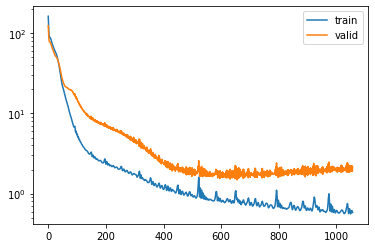

In [3]:
#
# Library Loading
#

import pandas as pd # manipulate dataframes
import matplotlib
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility
import time, h5py, imelt, torch, os

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 

# importing shutil module  
import shutil 

# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

#
# Data loading
#
# custom data loader, automatically sent to device
ds = imelt.data_loader("./data/NKAS_viscosity_reference.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",
                         device)

ds.print_data()

#
# Training 1 model 
#
 

# reference architecture: 4 layers, 200 neurons per layer, very low dropout
# Parameters were tuned after the random search, & learning rate by Bayesian Optimization & patience by hand.

nb_layers = 4
nb_neurons = 200
p_drop = 0.01

# search and create, if necessary, the folder for saving models and figures
# Create directories
dirName = './model/candidates/'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
dirName = './figures/single/'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")
    
name = "./model/candidates/l"+str(nb_layers)+"_n"+str(nb_neurons)+"_p"+str(p_drop)+"_test"+".pth"

# declaring model
neuralmodel = imelt.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 

# criterion for match
criterion = torch.nn.MSELoss(reduction='mean')
criterion.to(device) # sending criterion on device

# we initialize the output bias and send the neural net on device
neuralmodel.output_bias_init()
neuralmodel = neuralmodel.float()
neuralmodel.to(device)

#
# TRAINING
#
time1 = time.time()
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.0006) # optimizer
neuralmodel, record_train_loss, record_valid_loss = imelt.training(neuralmodel,ds,
                                                                     criterion,optimizer,save_switch=True,save_name=name,
                                                                     train_patience=400,min_delta=0.05,
                                                                     verbose=True)

time2 = time.time()
print("It took {:.1f} seconds".format(time2-time1))

print(name)
plt.figure()
plt.plot(record_train_loss,label="train")
plt.plot(record_valid_loss,label="valid")
plt.legend()
plt.yscale("log")
plt.savefig("./figures/single/loss.pdf")

#
# Print a metric to see performance
#

from sklearn.metrics import mean_squared_error

print("Viscosity RMSE on training and validation subsets are:")
print(mean_squared_error(neuralmodel.ag(ds.x_visco_train,ds.T_visco_train).cpu().detach().numpy(), ds.y_visco_train.cpu().detach().numpy(),squared=False))
print(mean_squared_error(neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid).cpu().detach().numpy(), ds.y_visco_valid.cpu().detach().numpy(),squared=False))

print("\n DONE")